# Stock Price Forecasting
We predict the (normalized) price at the timestep $t+1$ for each stock in the S&P 100 index. For this task, we use Spatio-Temporal Graph Neural Networks (STGNN) to model the spatial and temporal dependencies in the data.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader

from dataset.stock import StocksDataset
from models import A3TGCN, train, get_regression_error, plot_regression

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

/Users/amir/morningside-roarcast/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader.

In [2]:
seq_len = 25
dataset = StocksDataset(past_window=seq_len, force_reload=True)
dataset, dataset[0]

Processing...
Done!


(StocksDataset(2447),
 Data(x=[98, 8, 25], edge_index=[2, 638], y=[98, 1], edge_weight=[638], close_price=[98, 25], close_price_y=[98, 1]))

In [3]:
train_part = .9
batch_size = 32

train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

Train dataset: 2202, Test dataset: 245


Train using the training dataset and the Adam optimizer. Use `weight_decay` for L2 regularization (T-GCN paper). Calculate the loss using Mean Squared Error (MSE)

In [4]:
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2
model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat=False).to(device)

lr, weight_decay, num_epochs = 0.005, 1e-5, 16

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model

A3TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(8, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=40, out_features=16, bias=True)
      (lin_r): Linear(in_features=40, out_features=16, bias=True)
      (lin_c): Linear(in_features=40, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (attention): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Softmax(dim=1)
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [5]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, device, "PriceForecasting")

Epochs: 100%|██████████| 16/16 [14:55<00:00, 55.94s/it, Batch=100.0%]


In [18]:
with torch.no_grad():
    mse, rmse, mae, mre = get_regression_error(model, train_dataloader, device)
    print(f"Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Train MSE: 0.0036, RMSE: 0.0600, MAE: 0.0403, MRE: 0.0550


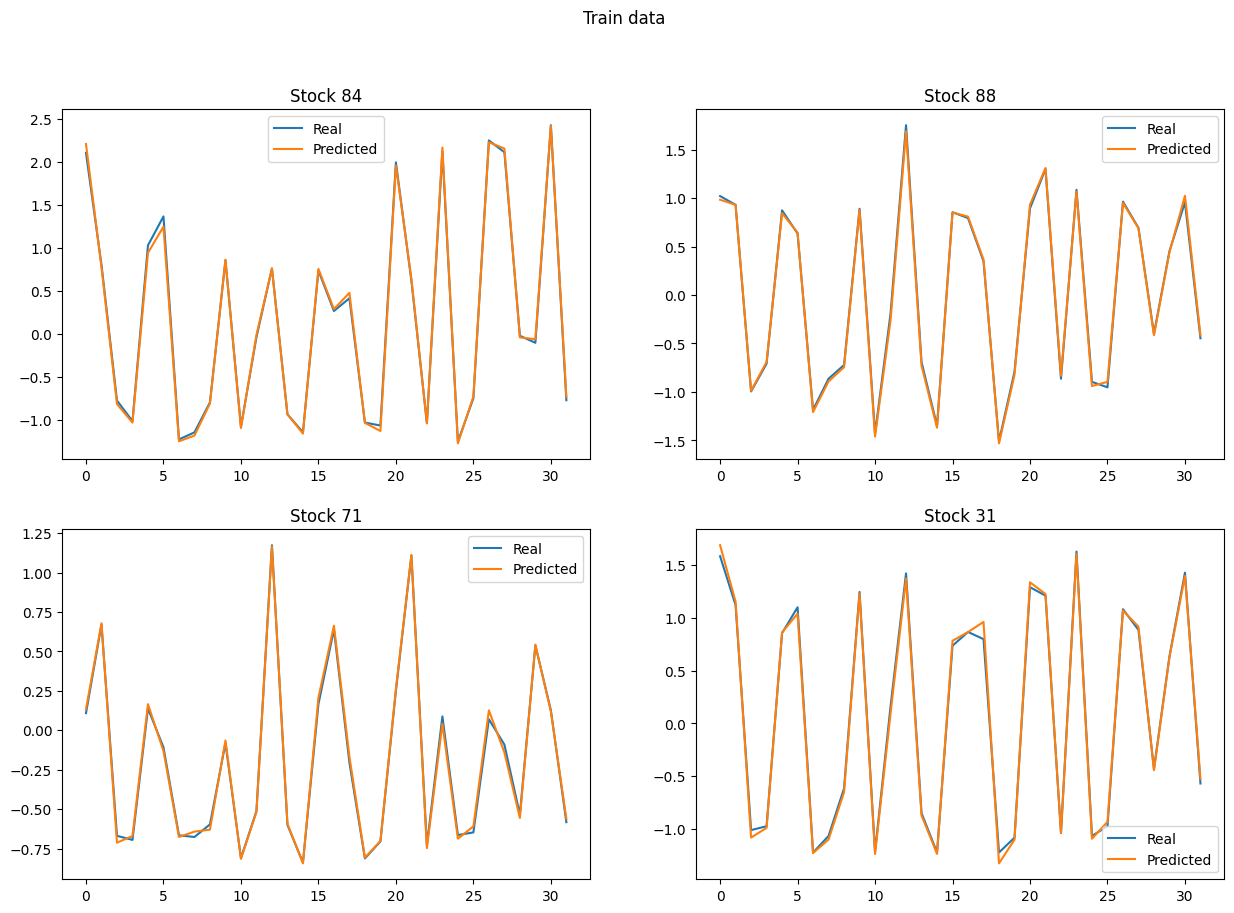

In [22]:
plot_regression(model, next(iter(train_dataloader)), device, "Train data")

In [23]:
with torch.no_grad():
    mse, rmse, mae, mre = get_regression_error(model, test_dataloader, device)
    print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Test MSE: 0.0238, RMSE: 0.1542, MAE: 0.0876, MRE: 0.0565


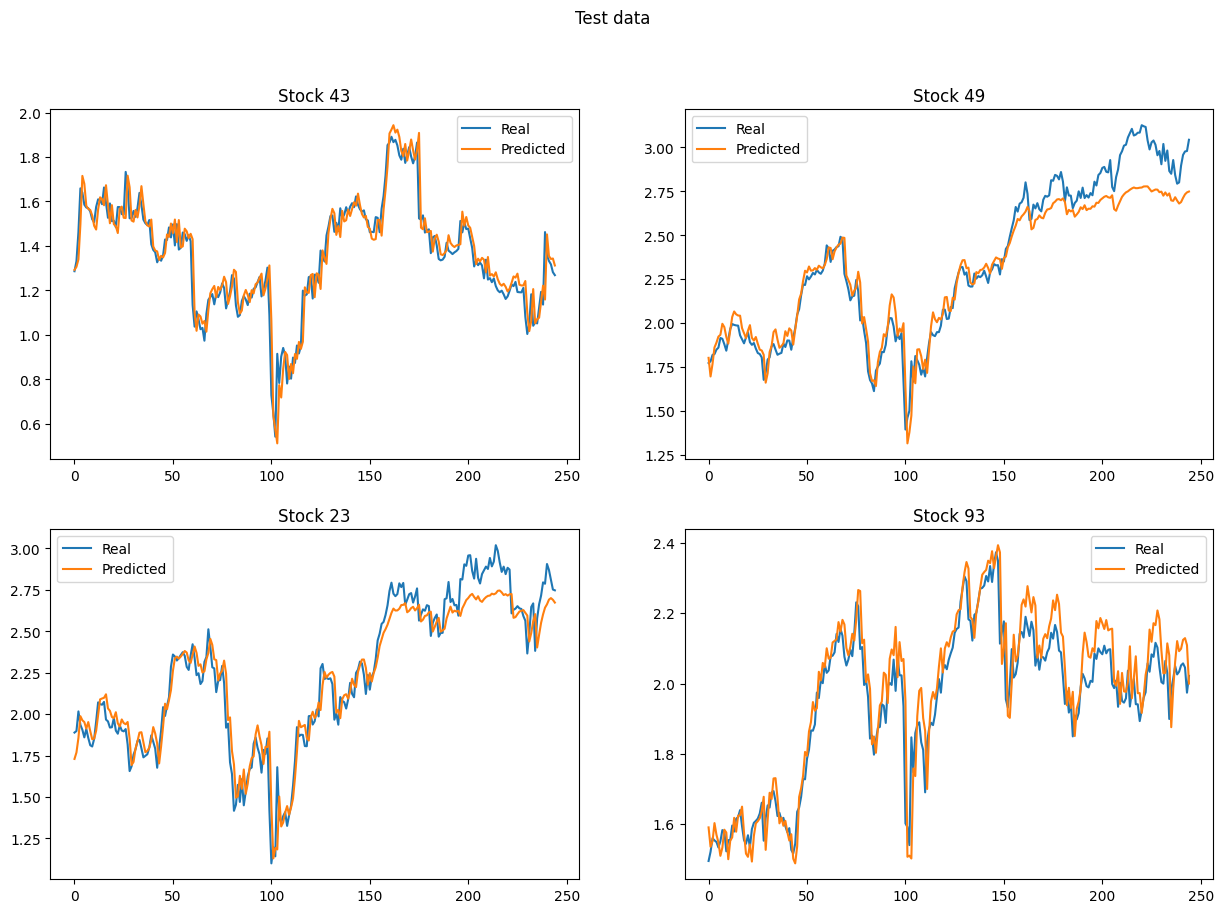

In [28]:
plot_regression(model, next(iter(test_dataloader)), device, "Test data")

In [27]:
torch.save(model.state_dict(), f"models/saved_models/PriceForecasting_{model.__class__.__name__}.pt")